## 2 识别数字序列的卷积神经网络

In [1]:
from __future__ import print_function
from six.moves import cPickle as pickle

In [2]:
% matplotlib inline
import seaborn

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### 加载经过预处理的数据

In [3]:
image_size_40px = ''
#image_size_40px = '_40'

In [4]:
pickle_file = 'svhn_multi_train%s.pickle' % image_size_40px

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)
    images = dataset['dataset']
    labels = dataset['labels'][:, 1:6]
    
print('dataset shape: ', images.shape)
print('labels shape: ', labels.shape)

dataset shape:  (33402, 32, 32)
labels shape:  (33402, 5)


In [5]:
pickle_file = 'svhn_multi_extra%s.pickle' % image_size_40px

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)
    images = np.vstack((images, dataset['dataset']))
    labels = np.vstack((labels, dataset['labels'][:, 1:6]))

print('dataset shape: ', images.shape)
print('labels shape: ', labels.shape)

dataset shape:  (235755, 32, 32)
labels shape:  (235755, 5)


In [6]:
labels[:10]

array([[ 1,  9, 10, 10, 10],
       [ 2,  3, 10, 10, 10],
       [ 2,  5, 10, 10, 10],
       [ 9,  3, 10, 10, 10],
       [ 3,  1, 10, 10, 10],
       [ 3,  3, 10, 10, 10],
       [ 2,  8, 10, 10, 10],
       [ 7,  4,  4, 10, 10],
       [ 1,  2,  8, 10, 10],
       [ 1,  6, 10, 10, 10]], dtype=int8)

### 构建交叉验证集

从训练数据中选择5%作为交叉验证集。

In [7]:
from sklearn.cross_validation import train_test_split

In [8]:
train_dataset, valid_dataset , train_labels, valid_labels = train_test_split(images, labels, test_size=0.05, random_state=42)

print('Training dataset shape: ', train_dataset.shape)
print('Training labels shape: ', train_labels.shape)
print('Validing dataset shape: ', valid_dataset.shape)
print('Validing labels shape: ', valid_labels.shape)

Training dataset shape:  (223967, 32, 32)
Training labels shape:  (223967, 5)
Validing dataset shape:  (11788, 32, 32)
Validing labels shape:  (11788, 5)


In [9]:
IMAGE_SIZE = 32
NUM_DIGITS = 5
NUM_LABELS = 11 # 0-9 + 10==doesn't exist
NUM_CHANNELS = 1 # grayscale

In [10]:
def reformat(dataset, labels):
    dataset = dataset.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)).astype(np.float32)

    return dataset, labels

In [11]:
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)

print('Training dataset shape: ', train_dataset.shape)
print('Validing dataset shape: ', valid_dataset.shape)

Training dataset shape:  (223967, 32, 32, 1)
Validing dataset shape:  (11788, 32, 32, 1)


### 构建计算图

训练的过程中，避免过拟合的方法：  

- 参数使用二范数正则化
- 早期停止
- 随机抛弃

In [12]:
def createWeight(shape, name):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name=name)

In [13]:
def createBiase(shape, name):
    return tf.Variable(tf.zeros(shape), name=name)

In [14]:
BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH_1 = 24
DEPTH_2 = 48
DEPTH_3 = 80
NUM_HIDDEN = 256
SEED = 42

In [17]:
graph = tf.Graph()
with graph.as_default():
    # 输入数据
    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
    tf_train_labels = tf.placeholder(tf.int64, shape=(None, NUM_DIGITS))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_valid_labels = tf.constant(valid_labels, dtype=tf.int64)
    
    # 模型参数-卷积层
    conv1_W = createWeight([PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS, DEPTH_1], 'conv1_weights')
    conv1_B = createBiase([DEPTH_1], 'conv1_biases')
    conv2_W = createWeight([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], 'conv2_weights')
    conv2_B = createBiase([DEPTH_2], 'conv2_biases')
    conv3_W = createWeight([PATCH_SIZE, PATCH_SIZE, DEPTH_2, DEPTH_3], 'conv3_weights')
    conv3_B = createBiase([DEPTH_3], 'conv3_biases')
    fc1_W = createWeight([IMAGE_SIZE//8 * IMAGE_SIZE//8 * DEPTH_3, NUM_HIDDEN], 'fc1_weights')
    fc1_B = createBiase([NUM_HIDDEN], 'fc1_biases')
    
    # 模型参数-全连接层
    fc_d1_W = createWeight([NUM_HIDDEN, NUM_LABELS], 'fc_digit1_weights')
    fc_d1_B = createBiase([NUM_LABELS], 'fc_digit1_biases')
    fc_d2_W = createWeight([NUM_HIDDEN, NUM_LABELS], 'fc_digit2_weights')
    fc_d2_B = createBiase([NUM_LABELS], 'fc_digit2_biases')
    fc_d3_W = createWeight([NUM_HIDDEN, NUM_LABELS], 'fc_digit3_weights')
    fc_d3_B = createBiase([NUM_LABELS], 'fc_digit3_biases')
    fc_d4_W = createWeight([NUM_HIDDEN, NUM_LABELS], 'fc_digit4_weights')
    fc_d4_B = createBiase([NUM_LABELS], 'fc_digit4_biases')
    fc_d5_W = createWeight([NUM_HIDDEN, NUM_LABELS], 'fc_digit5_weights')
    fc_d5_B = createBiase([NUM_LABELS], 'fc_digit5_biases')

    saver = tf.train.Saver(tf.trainable_variables()) # defaults to saving all variables
    
    # 数据通过神经网络前向传播
    def model(data, train=False):
        conv = tf.nn.conv2d(data, conv1_W, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_B))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, conv2_W, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_B))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, conv3_W, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv3_B))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [-1, shape[1]*shape[2]*shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, fc1_W) + fc1_B)
        
        if train:
            hidden = tf.nn.dropout(hidden, 0.6, seed=SEED)
            
        logit_d1 = tf.matmul(hidden, fc_d1_W) + fc_d1_B
        logit_d2 = tf.matmul(hidden, fc_d2_W) + fc_d2_B
        logit_d3 = tf.matmul(hidden, fc_d3_W) + fc_d3_B
        logit_d4 = tf.matmul(hidden, fc_d4_W) + fc_d4_B
        logit_d5 = tf.matmul(hidden, fc_d5_W) + fc_d5_B
        
        return logit_d1, logit_d2, logit_d3, logit_d4, logit_d5
    
    # 由logit计算出标签
    def predict(logits):
        return tf.transpose(tf.pack([tf.argmax(logits[0], 1), tf.argmax(logits[1], 1), tf.argmax(logits[2], 1), \
                        tf.argmax(logits[3], 1), tf.argmax(logits[4], 1)]))
    
    def accuracy(predictions, labels):
        return tf.reduce_mean(tf.cast(tf.reduce_all(
                    tf.equal(predictions, labels), reduction_indices=1
                ), tf.float32)) * 100
    
    logits = model(tf_train_dataset, True)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[0], tf_train_labels[:, 0])) + \
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[1], tf_train_labels[:, 1])) + \
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[2], tf_train_labels[:, 2])) + \
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[3], tf_train_labels[:, 3])) + \
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits[4], tf_train_labels[:, 4]))
    
    regularizers = tf.nn.l2_loss(fc1_W) + \
                tf.nn.l2_loss(fc_d1_W) + \
                tf.nn.l2_loss(fc_d2_W) + \
                tf.nn.l2_loss(fc_d3_W) + \
                tf.nn.l2_loss(fc_d4_W) + \
                tf.nn.l2_loss(fc_d5_W)
                
    loss += 1e-2 * regularizers
    
    batch = tf.Variable(0, dtype=tf.float32)
    
    learning_rate = tf.constant(0.04)
    
    #decayed_learning_rate = learning_rate *
    #                    decay_rate ^ (global_step / decay_steps)
#     learning_rate = tf.train.exponential_decay(
#         0.04, # Base learning rate
#         batch * BATCH_SIZE, # Current index into the dataset
#         train_labels.shape[0], # Decay step
#         0.95, # Decay rate,
#         staircase=True
#     )
    
    optimizer = tf.train.AdagradOptimizer(learning_rate, 0.9).minimize(loss, global_step=batch)
    
    train_prediction = predict(logits)
    valid_prediction = predict(model(tf_valid_dataset))
    
    train_accuracy = accuracy(train_prediction, tf_train_labels)
    valid_accuracy = accuracy(valid_prediction, tf_valid_labels)

In [18]:
def shuffle_in_unison_inplace(a, b):
    # 随机打乱数据，同时保证数据和标签仍然相互对应
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [19]:
SHOW_STATE_AFTER = 400

train_accuracies = []
valid_accuracies = []

best_valid_accuracy = 0
best_accuracy_step = 0
stop_after_step_no_progress = 5200


with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    offset = 0
    
    step = 0
    while True:
        step += 1
        # 扫描一遍训练数据后，随机打乱训练数据的顺序
        if(offset == 0):
            train_dataset, train_labels = shuffle_in_unison_inplace(train_dataset, train_labels)
            print('Random shuffle')
        feed_dict = {
            tf_train_dataset : train_dataset[offset:(offset + BATCH_SIZE)], 
            tf_train_labels : train_labels[offset:(offset + BATCH_SIZE)]
        }
        offset += BATCH_SIZE
        if offset+BATCH_SIZE > train_labels.shape[0]:
            offset = 0
        _, l, lr = session.run([optimizer, loss, learning_rate], feed_dict=feed_dict)
        
        
        if (step % SHOW_STATE_AFTER == 0):
            # 训练集准确率和交叉验证集准确率只需要在打印输出的时候计算
            train_acc, valid_acc = session.run([train_accuracy, valid_accuracy], feed_dict=feed_dict)
            
            # 星号表示交叉验证集上的准确率有提升
            improved_str = ''
            if valid_acc > best_valid_accuracy:
                saver.save(session, 'multi22.ckpt', write_meta_graph=False)
                best_valid_accuracy = valid_acc
                best_accuracy_step = step
                improved_str = '*'
            
            train_accuracies.append(train_acc)
            valid_accuracies.append(valid_acc)
            print('Step %d, \tMinibatch loss %.4f, Learning rate %.4f, Minibatch accuracy %.2f%%, \
                    Validation accuracy %.2f%% %s' % (step, l, lr, train_acc, valid_acc, improved_str))
            
            # stop_after_step_no_progress步内，交叉验证集准确率没有提升，终止训练
            if step - best_accuracy_step > stop_after_step_no_progress:
                print("Valid accuracy makes no progress in {} steps".format(stop_after_step_no_progress))
                break
#             if step >= 10000:
#                 saver.save(session, 'multi22.ckpt', write_meta_graph=False)
#                 break

Initialized
Random shuffle
Step 400, 	Minibatch loss 14.0714, Learning rate 0.0400, Minibatch accuracy 10.94%, Validation accuracy 26.46% *
Step 800, 	Minibatch loss 9.6776, Learning rate 0.0400, Minibatch accuracy 40.62%, Validation accuracy 45.77% *
Step 1200, 	Minibatch loss 7.9149, Learning rate 0.0400, Minibatch accuracy 48.44%, Validation accuracy 57.51% *
Step 1600, 	Minibatch loss 5.8784, Learning rate 0.0400, Minibatch accuracy 48.44%, Validation accuracy 63.27% *
Step 2000, 	Minibatch loss 4.7590, Learning rate 0.0400, Minibatch accuracy 60.94%, Validation accuracy 67.70% *
Step 2400, 	Minibatch loss 3.7672, Learning rate 0.0400, Minibatch accuracy 65.62%, Validation accuracy 70.33% *
Step 2800, 	Minibatch loss 2.9944, Learning rate 0.0400, Minibatch accuracy 70.31%, Validation accuracy 73.01% *
Step 3200, 	Minibatch loss 3.1685, Learning rate 0.0400, Minibatch accuracy 75.00%, Validation accuracy 74.20% *
Random shuffle
Step 3600, 	Minibatch loss 2.3480, Learning rate 0.0400

### 学习曲线

在训练过程中，准确率在训练集和交叉验证集上的变化情况。

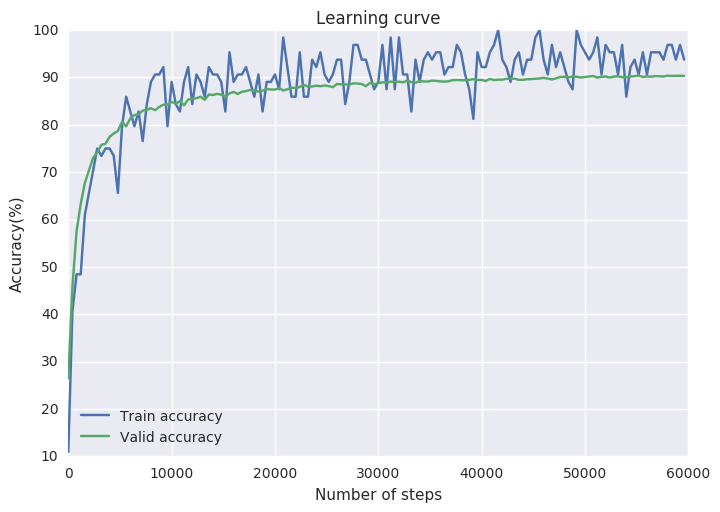

In [20]:
plt.plot(range(0, step, SHOW_STATE_AFTER), train_accuracies)
plt.plot(range(0, step, SHOW_STATE_AFTER), valid_accuracies)
plt.title('Learning curve')
plt.xlabel('Number of steps')
plt.ylabel('Accuracy(%)')
plt.legend(['Train accuracy', 'Valid accuracy'], loc='best')